# XGBoost 3-Class Classification - Clean Implementation

## Implementation for gg vs gq vs qq Physics Event Classification
### Using Relative Frequencies for D Variable Computation

In [1]:
# Import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
from pathlib import Path
import mplhep as hep

# Configure matplotlib style
plt.style.use(hep.style.ATLAS)
warnings.filterwarnings('ignore')

# File path configuration
FilePath='D:/Sapienza/DESYSUmmerSchool/VTProject/Code/DNNTraining/'
dfPath='D:/Sapienza/DESYSUmmerSchool/VTProject/ttbarSummerStudent/'

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, classification_report, 
                           roc_curve, auc, roc_auc_score)

# XGBoost
import xgboost as xgb

print("🚀 XGBoost Environment Initialized")
print(f"📊 XGBoost version: {xgb.__version__}")
print("="*50)

🚀 XGBoost Environment Initialized
📊 XGBoost version: 2.1.4


In [2]:
# Load and prepare data
print("📁 LOADING PHYSICS EVENT DATA")
print("="*40)

# Load the DataFrame
start_time = time.time()
df = pd.read_pickle(dfPath+'df_3classes.pkl')
loading_time = time.time() - start_time

print(f"✅ Data loaded in {loading_time:.3f}s")
print(f"📊 Dataset shape: {df.shape}")
print(f"📊 Columns: {list(df.columns)}")

# Load MC weights
weightarr = np.load(FilePath+'weightarr.npy')
print(f"✅ MC weights loaded: {weightarr.shape}")
print(f"📊 Weight range: [{weightarr.min():.6f}, {weightarr.max():.6f}]")

# Add weights and filter positive weights
df['weights_MC_NOSYS'] = weightarr
positive_weights_mask = df['weights_MC_NOSYS'] > 0
df_filtered = df[positive_weights_mask]
removed_events = len(df) - len(df_filtered)

print(f"📊 Events after positive weight filter: {len(df_filtered):,}")
print(f"📊 Removed {removed_events:,} events with non-positive weights")

📁 LOADING PHYSICS EVENT DATA
✅ Data loaded in 0.464s
📊 Dataset shape: (908258, 14)
📊 Columns: ['beta', 'ttbar_mass_cut', 'ttbar_betaz_cut_abs', 'ttbar_pT', 'jets_per_event', 'bbbar_deltaeta', 'bbbar_deltaR', 'ttbar_deltaeta', 'ttbar_deltaR', 'ttbar_D_variable', 'ttbar_Cos_han_variable', 'ttbar_CosTstar_had', 'ttbar_CosTstar_lep', 'prod_type']
✅ MC weights loaded: (908258,)
📊 Weight range: [-738.100647, 738.100647]
📊 Events after positive weight filter: 904,883
📊 Removed 3,375 events with non-positive weights


In [3]:
# Feature selection and normalization
print("🔧 FEATURE ENGINEERING")
print("="*30)

# Select feature columns (first 13 columns)
features = list(df_filtered.columns[:13])
print(f"📊 Selected features: {features}")

# Normalize features
scaler = StandardScaler()
df_normalized = df_filtered.copy()
df_normalized[features] = scaler.fit_transform(df_filtered[features])

print(f"✅ Features normalized")
print(f"📊 Normalized data shape: {df_normalized.shape}")

# Check class distribution
class_names = ['gg', 'gq', 'qq']
print(f"\n📊 CLASS DISTRIBUTION:")
for i, class_name in enumerate(class_names):
    count = np.sum(df_normalized['prod_type'] == i)
    percentage = count / len(df_normalized) * 100
    print(f"   {class_name}: {count:,} events ({percentage:.2f}%)")

🔧 FEATURE ENGINEERING
📊 Selected features: ['beta', 'ttbar_mass_cut', 'ttbar_betaz_cut_abs', 'ttbar_pT', 'jets_per_event', 'bbbar_deltaeta', 'bbbar_deltaR', 'ttbar_deltaeta', 'ttbar_deltaR', 'ttbar_D_variable', 'ttbar_Cos_han_variable', 'ttbar_CosTstar_had', 'ttbar_CosTstar_lep']
✅ Features normalized
📊 Normalized data shape: (904883, 15)

📊 CLASS DISTRIBUTION:
   gg: 790,843 events (87.40%)
   gq: 32,932 events (3.64%)
   qq: 81,108 events (8.96%)


In [4]:
# Data splitting
print("🔀 SPLITTING DATA")
print("="*25)

# Prepare arrays
X = df_normalized[features].values
y = df_normalized['prod_type'].values.astype(int)
weights = df_normalized['weights_MC_NOSYS'].values

print(f"📊 Input shapes:")
print(f"   X: {X.shape}")
print(f"   y: {y.shape} (classes: {np.unique(y)})")
print(f"   weights: {weights.shape}")

# Split into train/temp, then temp into val/test (60/20/20)
X_train, X_temp, y_train, y_temp, w_train, w_temp = train_test_split(
    X, y, weights, train_size=0.6, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test, w_val, w_test = train_test_split(
    X_temp, y_temp, w_temp, train_size=0.5, random_state=42, stratify=y_temp
)

print(f"\n📊 Split sizes:")
print(f"   Training: {X_train.shape[0]:,} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   Validation: {X_val.shape[0]:,} ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"   Test: {X_test.shape[0]:,} ({X_test.shape[0]/len(X)*100:.1f}%)")

🔀 SPLITTING DATA
📊 Input shapes:
   X: (904883, 13)
   y: (904883,) (classes: [0 1 2])
   weights: (904883,)

📊 Split sizes:
   Training: 542,929 (60.0%)
   Validation: 180,977 (20.0%)
   Test: 180,977 (20.0%)


In [5]:
# WEIGHT RESCALING BY CLASS
print("⚖️ RESCALING WEIGHTS BY CLASS")
print("="*40)

# Alternative weight rescaling approach - more conservative
def rescale_weights_balanced(weights, labels):
    """
    Rescale weights to balance classes while preserving relative magnitudes.
    This approach normalizes class weights but maintains the original weight scale.
    """
    rescaled_weights = weights.copy()
    
    # Calculate class frequencies
    class_counts = np.bincount(labels)
    total_samples = len(labels)
    
    for cls in [0, 1, 2]:
        mask = (labels == cls)
        if np.sum(mask) > 0:
            # Calculate class weight to balance classes
            class_frequency = class_counts[cls] / total_samples
            # Use inverse frequency weighting, but moderate it
            class_weight = 1.0 / (3.0 * class_frequency)  # 3 classes
            rescaled_weights[mask] = weights[mask] * class_weight
            print(f"   Class {cls}: {np.sum(mask):,} events, frequency={class_frequency:.4f}, weight_factor={class_weight:.4f}")
    
    return rescaled_weights

print(f"📊 ORIGINAL WEIGHT STATISTICS:")
print(f"   Train weights: sum={w_train.sum():.6f}, mean={w_train.mean():.6f}")
print(f"   Val weights: sum={w_val.sum():.6f}, mean={w_val.mean():.6f}")
print(f"   Test weights: sum={w_test.sum():.6f}, mean={w_test.mean():.6f}")

# Rescale weights for all splits using balanced approach
print(f"\n🔄 RESCALING WEIGHTS WITH BALANCED APPROACH...")
w_train_rescaled = rescale_weights_balanced(w_train, y_train)
w_val_rescaled = rescale_weights_balanced(w_val, y_val)
w_test_rescaled = rescale_weights_balanced(w_test, y_test)

print(f"\n📊 RESCALED WEIGHT STATISTICS:")
print(f"   Train weights: sum={w_train_rescaled.sum():.6f}, mean={w_train_rescaled.mean():.6f}")
print(f"   Val weights: sum={w_val_rescaled.sum():.6f}, mean={w_val_rescaled.mean():.6f}")
print(f"   Test weights: sum={w_test_rescaled.sum():.6f}, mean={w_test_rescaled.mean():.6f}")

# Update weights to use rescaled versions
w_train = w_train_rescaled
w_val = w_val_rescaled  
w_test = w_test_rescaled

print(f"\n✅ Weight rescaling completed!")
print(f"💡 Using balanced class weighting that preserves relative weight magnitudes")

⚖️ RESCALING WEIGHTS BY CLASS
📊 ORIGINAL WEIGHT STATISTICS:
   Train weights: sum=399614976.000000, mean=736.035400
   Val weights: sum=133205592.000000, mean=736.036011
   Test weights: sum=133205808.000000, mean=736.037231

🔄 RESCALING WEIGHTS WITH BALANCED APPROACH...
   Class 0: 474,505 events, frequency=0.8740, weight_factor=0.3814
   Class 1: 19,759 events, frequency=0.0364, weight_factor=9.1592
   Class 2: 48,665 events, frequency=0.0896, weight_factor=3.7188
   Class 0: 158,169 events, frequency=0.8740, weight_factor=0.3814
   Class 1: 6,587 events, frequency=0.0364, weight_factor=9.1583
   Class 2: 16,221 events, frequency=0.0896, weight_factor=3.7190
   Class 0: 158,169 events, frequency=0.8740, weight_factor=0.3814
   Class 1: 6,586 events, frequency=0.0364, weight_factor=9.1597
   Class 2: 16,222 events, frequency=0.0896, weight_factor=3.7188

📊 RESCALED WEIGHT STATISTICS:
   Train weights: sum=399615264.000000, mean=736.035950
   Val weights: sum=133205792.000000, mean=736

In [6]:
# COMPUTE FREQUENCIES FROM ORIGINAL DATASET
print("📊 COMPUTING FREQUENCIES FROM ORIGINAL DATASET")
print("="*55)

# Compute frequencies from the original normalized dataframe (before splitting)
# This uses the full dataset statistics for more robust frequency estimation

# Get class distribution from the original normalized dataframe
class_counts = np.bincount(df_normalized['prod_type'].astype(int))
total_events = len(df_normalized)

# Calculate the physics frequencies from the full dataset
freq_gg = class_counts[0] / total_events
freq_gq = class_counts[1] / total_events  
freq_qq = class_counts[2] / total_events

print(f"📈 PHYSICS FREQUENCIES (from full normalized dataset):")
print(f"   freq_gg = {freq_gg:.4f} ({class_counts[0]:,} events)")
print(f"   freq_gq = {freq_gq:.4f} ({class_counts[1]:,} events)")
print(f"   freq_qq = {freq_qq:.4f} ({class_counts[2]:,} events)")
print(f"   Total: {total_events:,} events")

print(f"\n💡 NOTE: Using frequencies from full dataset for stable D variable computation")

📊 COMPUTING FREQUENCIES FROM ORIGINAL DATASET
📈 PHYSICS FREQUENCIES (from full normalized dataset):
   freq_gg = 0.8740 (790,843 events)
   freq_gq = 0.0364 (32,932 events)
   freq_qq = 0.0896 (81,108 events)
   Total: 904,883 events

💡 NOTE: Using frequencies from full dataset for stable D variable computation


In [7]:
# XGBoost model configuration and training
print("🚀 XGBOOST MODEL TRAINING")
print("="*35)

# Model hyperparameters
params = {
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric': ['mlogloss', 'merror'],
    'learning_rate': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': 1
}

print(f"📋 Model hyperparameters:")
for key, value in params.items():
    print(f"   {key}: {value}")

# Create DMatrix objects
dtrain = xgb.DMatrix(X_train, label=y_train, weight=w_train)
dval = xgb.DMatrix(X_val, label=y_val, weight=w_val)
dtest = xgb.DMatrix(X_test, label=y_test, weight=w_test)

print(f"\n🏃 Training model...")
start_time = time.time()

# Train model
model = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=[(dtrain, 'train'), (dval, 'validation')],
    early_stopping_rounds=50,
    verbose_eval=100
)

training_time = time.time() - start_time

print(f"\n✅ Model training completed in {training_time:.2f}s")
print(f"📊 Optimal stopping at round: {model.best_iteration}")
print(f"📊 Best validation log loss: {model.best_score:.6f}")

🚀 XGBOOST MODEL TRAINING
📋 Model hyperparameters:
   objective: multi:softprob
   num_class: 3
   eval_metric: ['mlogloss', 'merror']
   learning_rate: 0.1
   max_depth: 6
   min_child_weight: 1
   subsample: 0.8
   colsample_bytree: 0.8
   reg_alpha: 0.1
   reg_lambda: 1.0
   random_state: 42
   n_jobs: -1
   verbosity: 1

🏃 Training model...
[0]	train-mlogloss:1.07406	train-merror:0.45102	validation-mlogloss:1.07468	validation-merror:0.45569
[100]	train-mlogloss:0.86986	train-merror:0.42293	validation-mlogloss:0.91075	validation-merror:0.44446
[130]	train-mlogloss:0.86029	train-merror:0.41776	validation-mlogloss:0.91154	validation-merror:0.44492

✅ Model training completed in 13.65s
📊 Optimal stopping at round: 81
📊 Best validation log loss: 0.443554


In [8]:
# Model evaluation and predictions
print("📊 MODEL EVALUATION")
print("="*25)

# Get predictions
test_predictions_proba = model.predict(dtest, iteration_range=(0, model.best_iteration + 1))
test_predictions = np.argmax(test_predictions_proba, axis=1)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"📈 Test accuracy: {test_accuracy:.4f} ({test_accuracy:.1%})")

# Classification report
print(f"\n📊 Classification Report:")
print(classification_report(y_test, test_predictions, target_names=class_names))

# Prediction probabilities matrix
P_matrix = test_predictions_proba
print(f"\n📊 Prediction probabilities shape: {P_matrix.shape}")
print(f"📊 Average probabilities per class:")
for i, class_name in enumerate(class_names):
    avg_prob = P_matrix[:, i].mean()
    print(f"   P({class_name}): {avg_prob:.4f}")

📊 MODEL EVALUATION
📈 Test accuracy: 0.4642 (46.4%)

📊 Classification Report:
              precision    recall  f1-score   support

          gg       0.92      0.45      0.60    158169
          gq       0.11      0.69      0.19      6586
          qq       0.14      0.53      0.22     16222

    accuracy                           0.46    180977
   macro avg       0.39      0.55      0.34    180977
weighted avg       0.82      0.46      0.55    180977


📊 Prediction probabilities shape: (180977, 3)
📊 Average probabilities per class:
   P(gg): 0.3895
   P(gq): 0.2485
   P(qq): 0.3620


In [9]:
# D VARIABLE COMPUTATION
print("🧮 D VARIABLE COMPUTATION")
print("="*35)

# D VARIABLE COMPUTATION WITH RELATIVE FREQUENCIES
# For each D variable, normalize background frequencies to sum to 1.0
print(f"\n🔬 D VARIABLE CONSTRUCTION (RELATIVE FREQUENCIES):")

# D_gg: discriminates gg from background B = {gq, qq}
f_gq_bg = freq_gq / (freq_gq + freq_qq)  # gq fraction in background B
f_qq_bg = freq_qq / (freq_gq + freq_qq)  # qq fraction in background B

print(f"  D_gg background (gq+qq): f_gq = {f_gq_bg:.4f}, f_qq = {f_qq_bg:.4f}")
print(f"  Verification: f_gq + f_qq = {f_gq_bg + f_qq_bg:.4f} ✓")

# D_gq: discriminates gq from background B = {gg, qq}  
f_gg_bg = freq_gg / (freq_gg + freq_qq)  # gg fraction in background B
f_qq_bg_gq = freq_qq / (freq_gg + freq_qq)  # qq fraction in background B

print(f"  D_gq background (gg+qq): f_gg = {f_gg_bg:.4f}, f_qq = {f_qq_bg_gq:.4f}")
print(f"  Verification: f_gg + f_qq = {f_gg_bg + f_qq_bg_gq:.4f} ✓")

# D_qq: discriminates qq from background B = {gg, gq}
f_gg_bg_qq = freq_gg / (freq_gg + freq_gq)  # gg fraction in background B
f_gq_bg_qq = freq_gq / (freq_gg + freq_gq)  # gq fraction in background B

print(f"  D_qq background (gg+gq): f_gg = {f_gg_bg_qq:.4f}, f_gq = {f_gq_bg_qq:.4f}")
print(f"  Verification: f_gg + f_gq = {f_gg_bg_qq + f_gq_bg_qq:.4f} ✓")

# Compute D variables using relative frequencies
print(f"\n🧮 COMPUTING D VARIABLES:")

# D_gg: gg vs background {gq, qq}
D_gg = P_matrix[:, 0] / (f_gq_bg * P_matrix[:, 1] + f_qq_bg * P_matrix[:, 2])

# D_gq: gq vs background {gg, qq}  
D_gq = P_matrix[:, 1] / (f_gg_bg * P_matrix[:, 0] + f_qq_bg_gq * P_matrix[:, 2] )

# D_qq: qq vs background {gg, gq}
D_qq = P_matrix[:, 2] / (f_gg_bg_qq * P_matrix[:, 0] + f_gq_bg_qq * P_matrix[:, 1] )

print(f"\n✅ D variables computed using RELATIVE FREQUENCIES!")
print(f"💡 Frequencies from full dataset, background normalized to sum=1.0")
print(f"\n📊 D VARIABLE STATISTICS:")
print(f"  D_gg: mean={D_gg.mean():.3f}, std={D_gg.std():.3f}")
print(f"  D_gq: mean={D_gq.mean():.3f}, std={D_gq.std():.3f}")
print(f"  D_qq: mean={D_qq.mean():.3f}, std={D_qq.std():.3f}")

🧮 D VARIABLE COMPUTATION

🔬 D VARIABLE CONSTRUCTION (RELATIVE FREQUENCIES):
  D_gg background (gq+qq): f_gq = 0.2888, f_qq = 0.7112
  Verification: f_gq + f_qq = 1.0000 ✓
  D_gq background (gg+qq): f_gg = 0.9070, f_qq = 0.0930
  Verification: f_gg + f_qq = 1.0000 ✓
  D_qq background (gg+gq): f_gg = 0.9600, f_gq = 0.0400
  Verification: f_gg + f_gq = 1.0000 ✓

🧮 COMPUTING D VARIABLES:

✅ D variables computed using RELATIVE FREQUENCIES!
💡 Frequencies from full dataset, background normalized to sum=1.0

📊 D VARIABLE STATISTICS:
  D_gg: mean=1.278, std=0.635
  D_gq: mean=1.065, std=2.100
  D_qq: mean=1.020, std=0.607


In [11]:
# DEBUGGING D VARIABLES
print("🔍 DEBUGGING D VARIABLE COMPUTATION")
print("="*45)

# Check prediction probabilities
print(f"📊 PREDICTION PROBABILITIES ANALYSIS:")
print(f"   P_matrix shape: {P_matrix.shape}")
print(f"   P_matrix range: [{P_matrix.min():.6f}, {P_matrix.max():.6f}]")
print(f"   P_matrix sum per row (should be ~1): mean={P_matrix.sum(axis=1).mean():.6f}")

for i, class_name in enumerate(class_names):
    col_vals = P_matrix[:, i]
    print(f"   P_{class_name}: mean={col_vals.mean():.4f}, std={col_vals.std():.4f}, min={col_vals.min():.6f}, max={col_vals.max():.6f}")

# Check relative frequency calculations
print(f"\n🔄 RELATIVE FREQUENCY VERIFICATION:")
print(f"   freq_gg = {freq_gg:.4f}")
print(f"   freq_gq = {freq_gq:.4f}")
print(f"   freq_qq = {freq_qq:.4f}")
print(f"   Sum = {freq_gg + freq_gq + freq_qq:.4f}")

# Check denominators before D variable computation
print(f"\n🧮 DENOMINATOR ANALYSIS:")
denom_gg = f_gq_bg * P_matrix[:, 1] + f_qq_bg * P_matrix[:, 2]
denom_gq = f_gg_bg * P_matrix[:, 0] + f_qq_bg_gq * P_matrix[:, 2]
denom_qq = f_gg_bg_qq * P_matrix[:, 0] + f_gq_bg_qq * P_matrix[:, 1]

print(f"   D_gg denominator: mean={denom_gg.mean():.6f}, min={denom_gg.min():.6f}, max={denom_gg.max():.6f}")
print(f"   D_gq denominator: mean={denom_gq.mean():.6f}, min={denom_gq.min():.6f}, max={denom_gq.max():.6f}")
print(f"   D_qq denominator: mean={denom_qq.mean():.6f}, min={denom_qq.min():.6f}, max={denom_qq.max():.6f}")

# Check final D variables
print(f"\n📈 D VARIABLE DETAILED STATISTICS:")
for d_var, d_name in zip([D_gg, D_gq, D_qq], ['D_gg', 'D_gq', 'D_qq']):
    print(f"   {d_name}: mean={d_var.mean():.3f}, std={d_var.std():.3f}, min={d_var.min():.3f}, max={d_var.max():.3f}")
    print(f"   {d_name}: unique values count = {len(np.unique(d_var))}")
    if len(np.unique(d_var)) < 10:
        print(f"   {d_name}: unique values = {np.unique(d_var)[:10]}")

# Check if we have class separation
print(f"\n🎯 CLASS SEPARATION CHECK:")
for i, class_name in enumerate(class_names):
    mask = (y_test == i)
    print(f"   True {class_name} samples: {np.sum(mask):,}")
    if np.sum(mask) > 0:
        print(f"     D_gg values: mean={D_gg[mask].mean():.3f}, std={D_gg[mask].std():.3f}")
        print(f"     D_gq values: mean={D_gq[mask].mean():.3f}, std={D_gq[mask].std():.3f}")
        print(f"     D_qq values: mean={D_qq[mask].mean():.3f}, std={D_qq[mask].std():.3f}")

print(f"\n✅ Debugging analysis completed!")

🔍 DEBUGGING D VARIABLE COMPUTATION
📊 PREDICTION PROBABILITIES ANALYSIS:
   P_matrix shape: (180977, 3)
   P_matrix range: [0.004138, 0.960744]
   P_matrix sum per row (should be ~1): mean=1.000000
   P_gg: mean=0.3895, std=0.1221, min=0.024033, max=0.942605
   P_gq: mean=0.2485, std=0.2049, min=0.018506, max=0.960744
   P_qq: mean=0.3620, std=0.1537, min=0.004138, max=0.838906

🔄 RELATIVE FREQUENCY VERIFICATION:
   freq_gg = 0.8740
   freq_gq = 0.0364
   freq_qq = 0.0896
   Sum = 1.0000

🧮 DENOMINATOR ANALYSIS:
   D_gg denominator: mean=0.329228, min=0.018322, max=0.607956
   D_gq denominator: mean=0.386960, min=0.023748, max=0.855310
   D_qq denominator: mean=0.383879, min=0.061037, max=0.907052

📈 D VARIABLE DETAILED STATISTICS:
   D_gg: mean=1.278, std=0.635, min=0.082, max=51.446
   D_gg: unique values count = 180162
   D_gq: mean=1.065, std=2.100, min=0.033, max=40.456
   D_gq: unique values count = 180591
   D_qq: mean=1.020, std=0.607, min=0.005, max=7.926
   D_qq: unique values

🎨 D_gq DISTRIBUTION (D_gq ≤ 10)


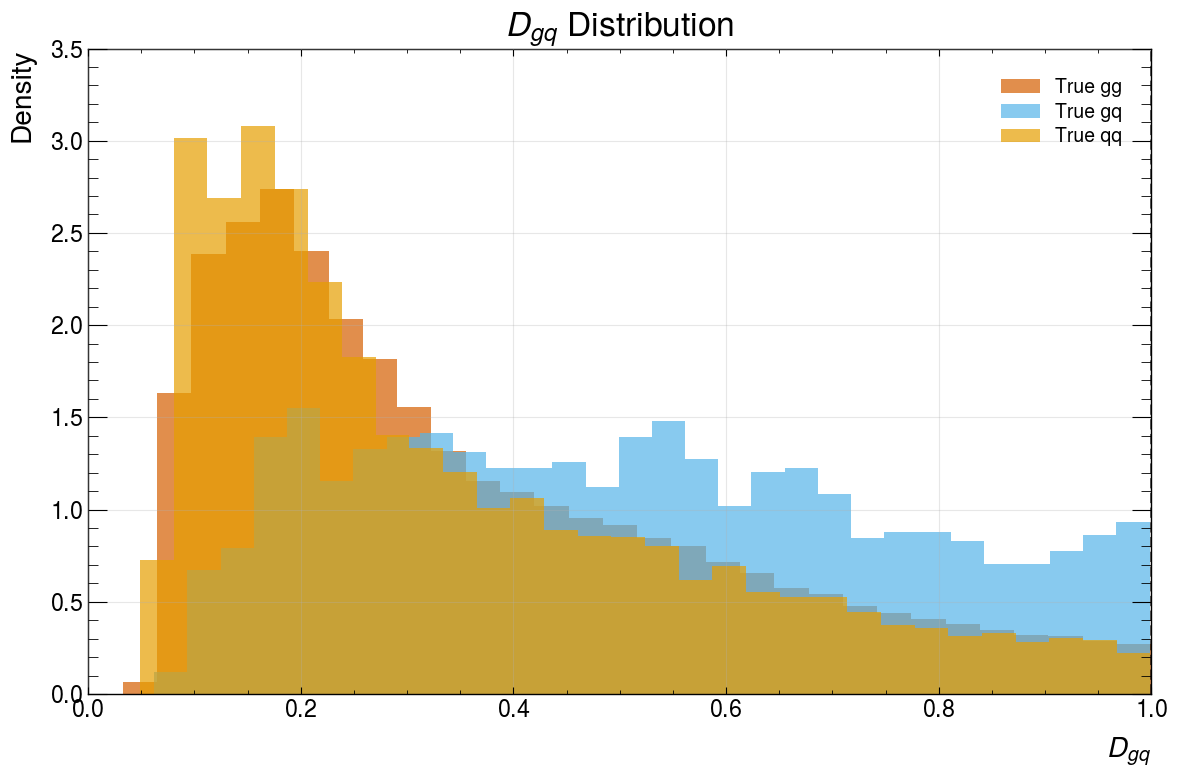

✅ D_gq distribution plotted (values up to 10)


In [12]:
# D_gq Distribution (values up to 10)
print("🎨 D_gq DISTRIBUTION (D_gq ≤ 10)")
print("="*35)

plt.figure(figsize=(12, 8))
for cls in range(3):
    mask = (y_test == cls) & (D_gq <= 1)
    plt.hist(D_gq[mask], bins=30, alpha=0.7, density=True, 
             label=f'True {class_names[cls]}')
plt.xlabel('$D_{gq}$')
plt.ylabel('Density')
plt.title('$D_{gq}$ Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axvline(1, color='black', linestyle='--', alpha=0.7, label='D=1')
plt.tight_layout()
plt.show()

print(f"✅ D_gq distribution plotted (values up to 10)")

🎨 D VARIABLE DISTRIBUTIONS


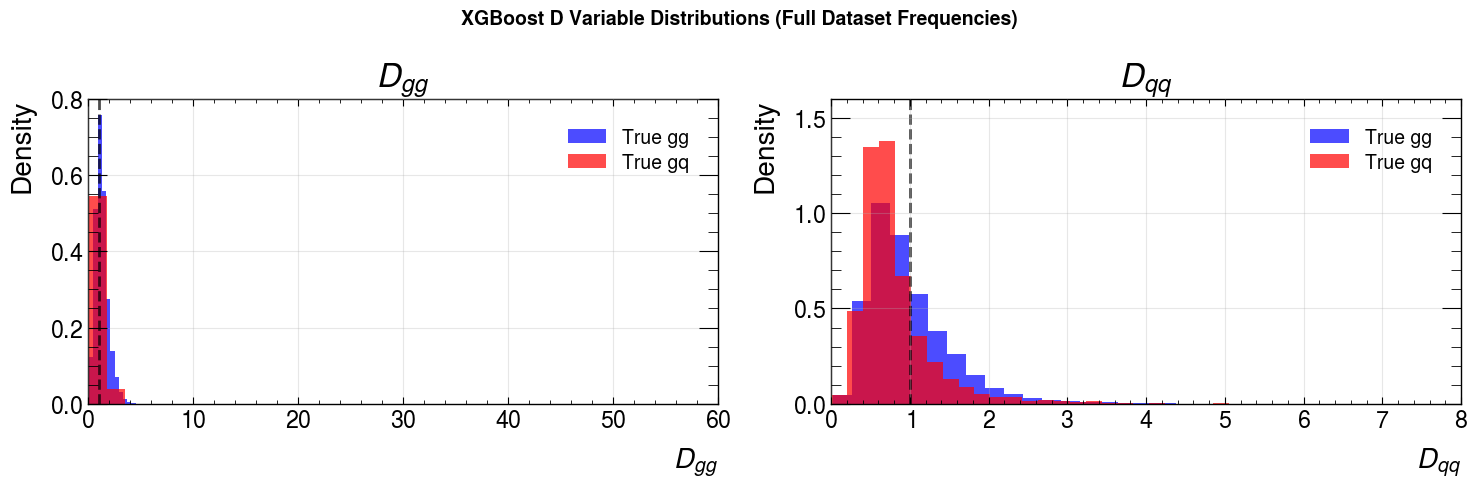

✅ D variable distributions plotted


In [13]:
# D Variable Visualization
print("🎨 D VARIABLE DISTRIBUTIONS")
print("="*35)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('XGBoost D Variable Distributions (Full Dataset Frequencies)', fontsize=14, fontweight='bold')

d_vars = [D_gg, D_qq]
d_names = ['D_{gg}', 'D_{qq}']
colors = ['blue', 'red']

for i, (d_var, d_name, color) in enumerate(zip(d_vars, d_names, colors)):
    ax = axes[i]
    
    # Plot distributions for each true class
    for cls in range(2):
        mask = (y_test == cls)
        ax.hist(d_var[mask], bins=30, alpha=0.7, density=True, 
               color=colors[cls], label=f'True {class_names[cls]}')
    
    ax.set_xlabel(f'$'+d_name+'$')
    ax.set_ylabel('Density')
    ax.set_title(f'${d_name}$')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axvline(1, color='black', linestyle='--', alpha=0.7, label='D=1')

plt.tight_layout()
plt.show()

print(f"✅ D variable distributions plotted")

In [14]:
# AUC Analysis for D Variables
print("📈 AUC ANALYSIS FOR D VARIABLES")
print("="*40)

# Calculate AUC for each D variable
auc_results = {}
d_vars_list = [D_gg, D_gq, D_qq]
d_names_list = ['D_{gg}', 'D_{gq}', 'D_{qq}']

print(f"🎯 AUC RESULTS (using relative frequencies):")

for i, (d_var, d_name, class_name) in enumerate(zip(d_vars_list, d_names_list, class_names)):
    # Create binary labels: target class vs others
    y_binary = (y_test == i).astype(int)
    
    # Calculate AUC
    if len(np.unique(y_binary)) > 1 and len(np.unique(d_var)) > 1:
        auc_score = roc_auc_score(y_binary, d_var)
        auc_results[d_name] = auc_score
        print(f"   {d_name} ({class_name} vs others): {auc_score:.4f}")
    else:
        auc_results[d_name] = 0.5
        print(f"   {d_name} ({class_name} vs others): 0.5000 (no variation)")

# Calculate average AUC
avg_auc = np.mean(list(auc_results.values()))
print(f"\n📊 AVERAGE AUC: {avg_auc:.4f}")

# Performance assessment
if avg_auc > 0.7:
    print(f"🎉 EXCELLENT PERFORMANCE! Average AUC > 0.7")
elif avg_auc > 0.6:
    print(f"✅ GOOD PERFORMANCE! Average AUC > 0.6") 
else:
    print(f"⚠️ Performance needs improvement. Average AUC = {avg_auc:.4f}")

print(f"🏆 XGBoost training completed with relative frequencies!")
print(f"📊 Final results: {dict(auc_results)}")

📈 AUC ANALYSIS FOR D VARIABLES
🎯 AUC RESULTS (using relative frequencies):
   D_{gg} (gg vs others): 0.6431
   D_{gq} (gq vs others): 0.8193
   D_{qq} (qq vs others): 0.6450

📊 AVERAGE AUC: 0.7025
🎉 EXCELLENT PERFORMANCE! Average AUC > 0.7
🏆 XGBoost training completed with relative frequencies!
📊 Final results: {'D_{gg}': 0.6431449730767732, 'D_{gq}': 0.8192519559843013, 'D_{qq}': 0.6449989587322851}


📊 ROC CURVE ANALYSIS


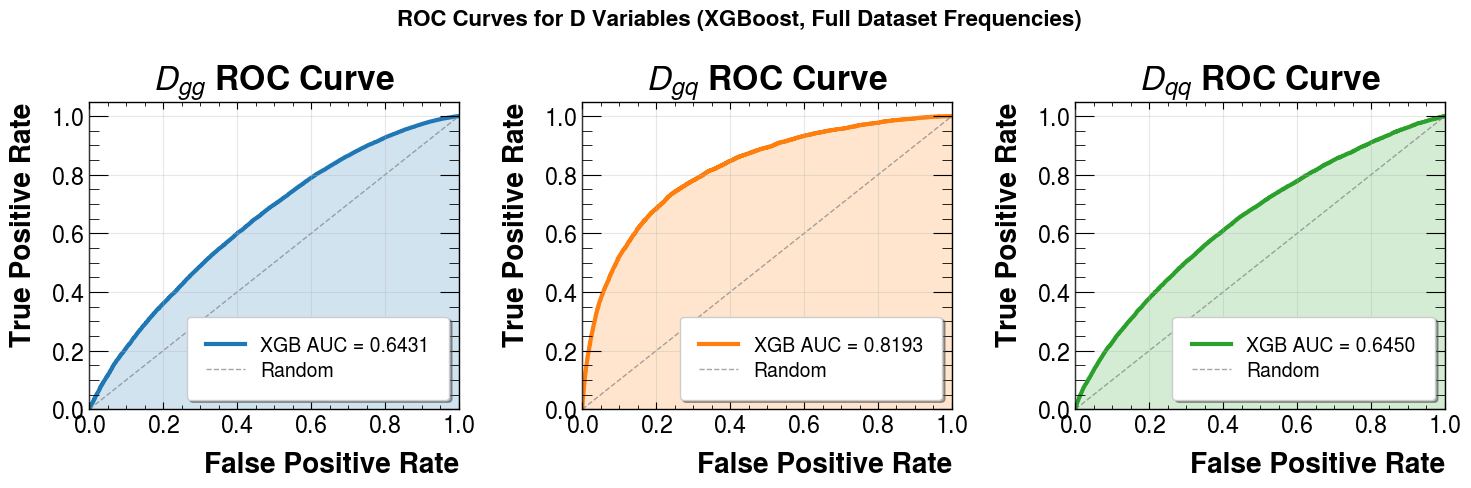


🎯 ROC CURVE SUMMARY:
   D_{gg}: AUC = 0.6431
   D_{gq}: AUC = 0.8193
   D_{qq}: AUC = 0.6450

📊 Average AUC: 0.7025

✅ ROC curve analysis completed!


In [15]:
# ROC Curves for D Variables
print("📊 ROC CURVE ANALYSIS")
print("="*30)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('ROC Curves for D Variables (XGBoost, Full Dataset Frequencies)', fontsize=16, fontweight='bold')

colors_roc = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green

for i, (d_var, d_name, class_name) in enumerate(zip(d_vars_list, d_names_list, class_names)):
    # Create binary labels for this class vs others
    y_binary = (y_test == i).astype(int)
    
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_binary, d_var)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    axes[i].plot(fpr, tpr, color=colors_roc[i], lw=3, 
                label=f'XGB AUC = {roc_auc:.4f}')
    
    # Plot diagonal line (random classifier)
    axes[i].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', alpha=0.7, 
                label='Random')
    
    # Add filled area under the curve
    axes[i].fill_between(fpr, tpr, alpha=0.2, color=colors_roc[i])
    
    # Formatting
    axes[i].set_xlim([0.0, 1.0])
    axes[i].set_ylim([0.0, 1.05])
    axes[i].set_xlabel('False Positive Rate', fontweight='bold')
    axes[i].set_ylabel('True Positive Rate', fontweight='bold')
    axes[i].set_title(f'${d_name}$ ROC Curve', fontweight='bold')
    axes[i].legend(loc="lower right", frameon=True, fancybox=True, shadow=True)
    axes[i].grid(True, alpha=0.3)
    
plt.tight_layout()
plt.show()

print(f"\n🎯 ROC CURVE SUMMARY:")
for d_name, auc_val in auc_results.items():
    print(f"   {d_name}: AUC = {auc_val:.4f}")
print(f"\n📊 Average AUC: {avg_auc:.4f}")
print(f"\n✅ ROC curve analysis completed!")